# EDA example - Marketing analytics

1. [Wrangling data](#section1)

   1.1 [Fix columns](#section1.1)   
   1.2 [Missing values](#section1.2)  
   1.3 [Outliers](#section1.3)
   1.4 [Transformations](section1.4)
  
2. [Understand the data](#section2)
3. [Correlations](#section3)

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We'll work with a small marketing analytics dataset, taken from [iFood](https://www.crunchbase.com/organization/ifood)

Based on the example [here](https://www.kaggle.com/jennifercrockett/marketing-analytics-eda-task-final)

In [ ]:
url = 'https://raw.githubusercontent.com/nlihin/data-analytics/main/datasets/marketing_data.csv'
mrkt_df = pd.read_csv(url)
mrkt_df.head()

Data description in an image, and also [here](https://www.kaggle.com/jackdaoud/marketing-data)

<div>
<img src="images/ifood.png" width="700"/>
</div>

<a id='section1'></a>

---
### 1. Wrangling data



<a id='section1.1'></a>

#### 1.1 Fix columns

You may already notice something is strange with the Income column, is it aligned to the right??

Let's look at the types of data

In [ ]:
mrkt_df.dtypes

So here is the problem: the 'Income' column contains extra whitespace, clean it:

In [56]:
mrkt_df.columns = mrkt_df.columns.str.replace(' ', '')

And: the 'Income' column should be turned to numeric (float is better)

In [ ]:
# transform Income column to a numerical
mrkt_df['Income'] = mrkt_df['Income'].str.replace('$', '')
mrkt_df['Income'] = mrkt_df['Income'].str.replace(',', '').astype('float')

Check that our changes worked:

In [58]:
mrkt_df.dtypes['Income']

dtype('float64')

Change the date column to a date type

In [59]:
mrkt_df['Dt_Customer'] = pd.to_datetime(mrkt_df['Dt_Customer'])

<a id='section1.2'></a>

#### 1.2 Missing values

In [ ]:
mrkt_df.isnull().sum().sort_values(ascending=False)

The feature Income contains 24 null values

Plot this feature to identify best strategy for imputation



In [ ]:
mrkt_df.hist('Income')

Try more bins to get a better idea:

In [ ]:
mrkt_df.hist('Income',bins=100)

<AxesSubplot:>

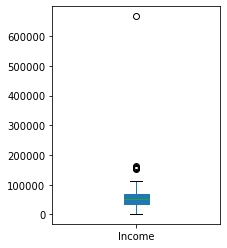

In [63]:
mrkt_df['Income'].plot(kind='box', figsize=(3,4), patch_artist=True)

Findings:

Most incomes are distributed between $0-\$100,000, with a few outliers

Replace null values with median value, to avoid effects of outliers on imputation value

In [ ]:
mrkt_df['Income'] = mrkt_df['Income'].fillna(mrkt_df['Income'].median())

<a id='section1.3'></a>

#### 1.3 Noisy data - outliers

Plot only numeric columns, that are not binary or an ID:

In [ ]:
#remove binary and ID
df_to_plot = mrkt_df.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain'])

#numeric
df_to_plot = df_to_plot.select_dtypes(include=np.number)


In [ ]:
# subplots
df_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

Findings: 

Multiple features contain outliers (see boxplots), but the only that likely indicate data entry errors are Year_Birth <= 1900

Remove people born before 1900: 

In [ ]:
mrkt_df = mrkt_df[mrkt_df['Year_Birth'] > 1900].reset_index(drop=True)

Check:

In [ ]:
plt.figure(figsize=(3,4))
mrkt_df['Year_Birth'].plot(kind='box', patch_artist=True);

You can also plot via pandas:

In [ ]:
mrkt_df.boxplot('Year_Birth')

<a id='section1.1'></a>

#### 1.4 Transformations

In [ ]:
mrkt_df.info()

Transform the date to a datetime object:

In [71]:
mrkt_df['Dt_Customer'] = pd.to_datetime(mrkt_df['Dt_Customer'])

<a id='section2'></a>

### 2. Understand the data

The total number of dependents in the home ('Dependents') can be engineered from the sum of 'Kidhome' and 'Teenhome'

In [72]:
mrkt_df['Dependents'] = mrkt_df['Kidhome'] + mrkt_df['Teenhome']

The year of becoming a customer ('Year_Customer') can be engineered from 'Dt_Customer'

In [73]:
mrkt_df['Year_Customer'] = pd.DatetimeIndex(mrkt_df['Dt_Customer']).year

The total amount spent ('TotalMnt') can be engineered from the sum of all features containing the keyword 'Mnt'

We will use [list comprehension](https://docs.python.org/3.4/tutorial/datastructures.html#list-comprehensions) to do that 

A list comprehension consists of brackets containing an expression followed by a for clause, then zero or more for or if clauses. 

In [74]:
squares = []
for x in range(10):
    squares.append(x**2)
    squares
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [75]:
squares = [x**2 for x in range(10)]
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [76]:
mnt_cols = [col for col in mrkt_df.columns if 'Mnt' in col]
mnt_cols

['MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds']

We have used `.sum()` to sum by columns. Now we want to sum rows. So `axis=1`

In [77]:
mrkt_df['TotalMnt'] = mrkt_df[mnt_cols].sum(axis=1)

The total purchases ('TotalPurchases') can be engineered from the sum of all features containing the keyword 'Purchases'

In [78]:
purchases_cols = [col for col in mrkt_df.columns if 'Purchases' in col]
mrkt_df['TotalPurchases'] = mrkt_df[purchases_cols].sum(axis=1)

The total number of campains accepted ('TotalCampaignsAcc') can be engineered from the sum of all features containing the keywords 'Cmp' and 'Response' (the latest campaign)

In [79]:
campaigns_cols = [col for col in mrkt_df.columns if 'Cmp' in col] + ['Response'] # 'Response' is for the latest campaign
mrkt_df['TotalCampaignsAcc'] = mrkt_df[campaigns_cols].sum(axis=1)

In [ ]:
mrkt_df[['ID', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc']].head()

<a id='section3'></a>

### 3. Correlations - patterns in the data

To find patterns in the data, we need to find correlations in the data

In [ ]:
# calculate correlation matrix
## using non-parametric test of correlation (kendall), since some features are binary
corrs = mrkt_df.drop(columns='ID').select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0);

In [ ]:
corrs = mrkt_df[['Income', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc']].select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0);

Plot illustrating the effect of high income on spending:

In [ ]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df);

the same, but remove the outliers:

In [ ]:
sns.regplot(x='Income', y='TotalMnt', data=mrkt_df[mrkt_df['Income'] < 200000]);

Plot illustrating negative effect of having dependents (kids & teens) on spending:
    
A linear plot doesn't look good here since data is discrete (same for ordinal data - e.g. - none, few, many)

In [ ]:
sns.regplot(x='Dependents', y='TotalMnt', data=mrkt_df);

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='TotalMnt', data=mrkt_df);

Plot illustrating positive effect of having dependents (kids & teens) on number of deals purchased:

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='NumDealsPurchases', data=mrkt_df);

Plots illustrating the positive effect of income 

In [ ]:
plt.figure(figsize=(5.5,4))
sns.boxplot(x='TotalCampaignsAcc', y='Income', data=mrkt_df[mrkt_df['Income']<200000]);

Number of web visits in the last month is not positively correlated with number of web purchases

Instead, it is positively correlated with the number of deals purchased, suggesting that deals are an effective way of stimulating purchases on the website

In [ ]:
corrs = mrkt_df[['NumWebVisitsMonth', 'NumWebPurchases', 'NumDealsPurchases', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc']].select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0,  annot=True);

In [ ]:
sns.lmplot(x='NumWebVisitsMonth', y='NumWebPurchases', data=mrkt_df)

In [ ]:
sns.lmplot(x='NumWebVisitsMonth', y='NumDealsPurchases', data=mrkt_df)

---
> A summary of new functions:
>
>* `.drop()` - remove labels or columns [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html?highlight=drop#pandas.DataFrame.drop)
>
>* `.str.replace('x','y')` - replace string x with string y
>
>* `.reset_index(drop=true)` - resets the index. As defult, the old index is added as a column. Use drop=True to avoid this. [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html)
>
>* `plot` - a matplotlib function
>
>* `plt.subplots_adjust` - a matplotlib function. adjusts space between the plots. [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html)
>
>* `sum(axis=1)` - sums the values according to the rows, instead of the default sum by columns
>
>* create a list using [list comprehension](https://docs.python.org/3.4/tutorial/datastructures.html#list-comprehensions) - "do something for data in dataframe if condition holds"


---